In [1]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from model import train_sia
import shap
import utils
import scikitplot as skplt
import matplotlib.pyplot as plt
import warnings
from datalayer import read_sia_model

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

### Radioterapia

In [2]:
data_model = read_sia_model('../data/Linfomas Radioterapia SIA-SUS.csv', method='radioterapia')

Reading csv...
Transforming csv to train...


In [3]:
%time model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia(data_model)

training model...
ROC_AUC_SCORE: 55.75%
CPU times: user 4.34 s, sys: 12.3 ms, total: 4.35 s
Wall time: 4.35 s


#### Roc Curves

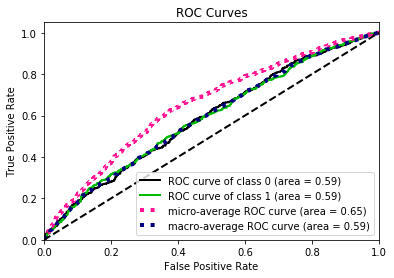

In [9]:
skplt.metrics.plot_roc_curve(y_test, prob_preds)
plt.show()

#### Shapley Values - Relevance

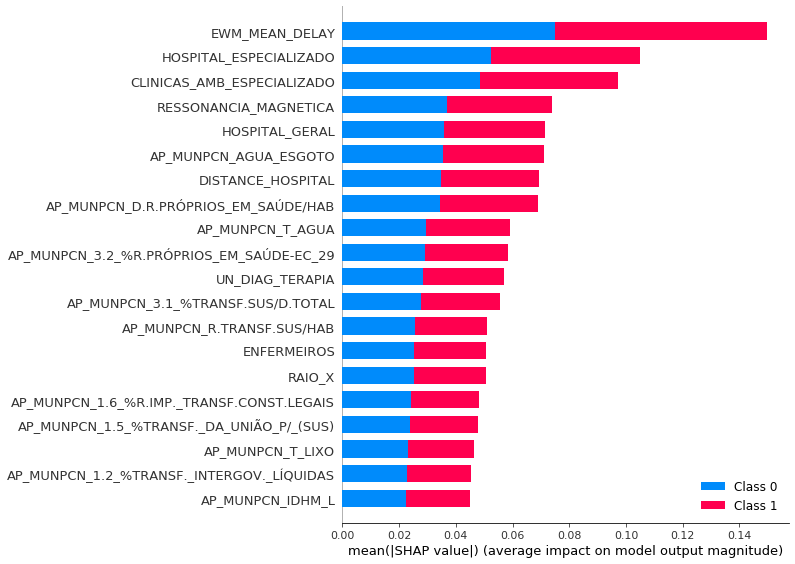

In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

### Quimioterapia

In [5]:
data_model = read_sia_model('../data/Linfomas Quimioterapia SIA-SUS.csv', method='quimioterapia')

%time model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia(data_model)

Reading csv...
Transforming csv to train...
training model...
ROC_AUC_SCORE: 65.47%
CPU times: user 40.7 s, sys: 123 ms, total: 40.8 s
Wall time: 40.9 s


#### Roc Curves

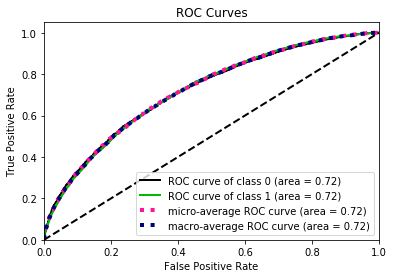

In [6]:
skplt.metrics.plot_roc_curve(y_test, prob_preds)
plt.show()

#### Shapley Values - Relevance

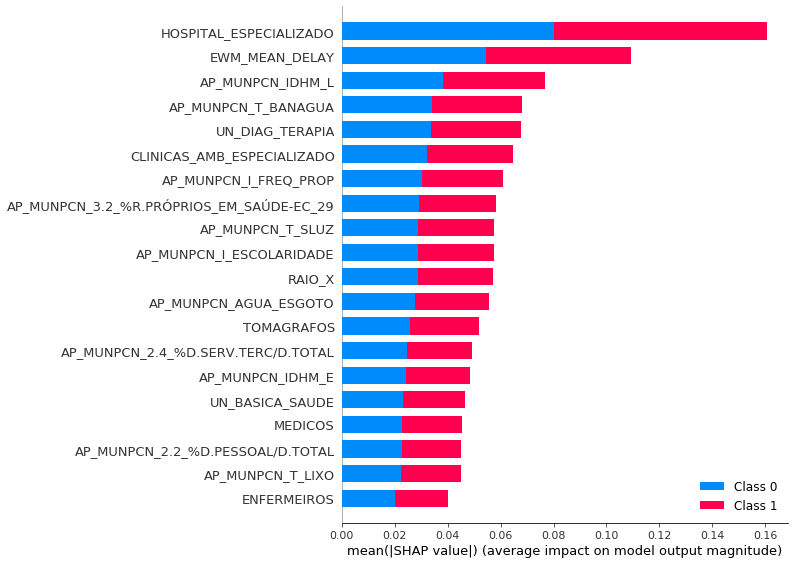

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

### Radioterapia + Quimioterapia

In [7]:
radioterapia = read_sia_model('../data/Linfomas Radioterapia SIA-SUS.csv', method='radioterapia')
quimioterapia = read_sia_model('../data/Linfomas Quimioterapia SIA-SUS.csv', method='quimioterapia')

Reading csv...
Transforming csv to train...
Reading csv...
Transforming csv to train...


In [11]:
total = pd.concat([radioterapia, quimioterapia])

In [13]:
model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia(total)

training model...
ROC_AUC_SCORE: 63.90%


#### Roc Curves

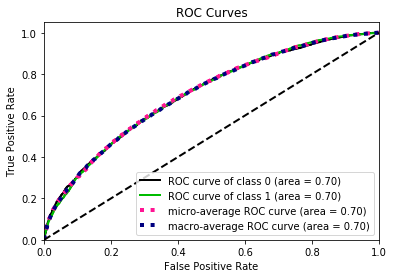

In [15]:
skplt.metrics.plot_roc_curve(y_test, prob_preds)
plt.show()

#### Shapley Values - Relevance

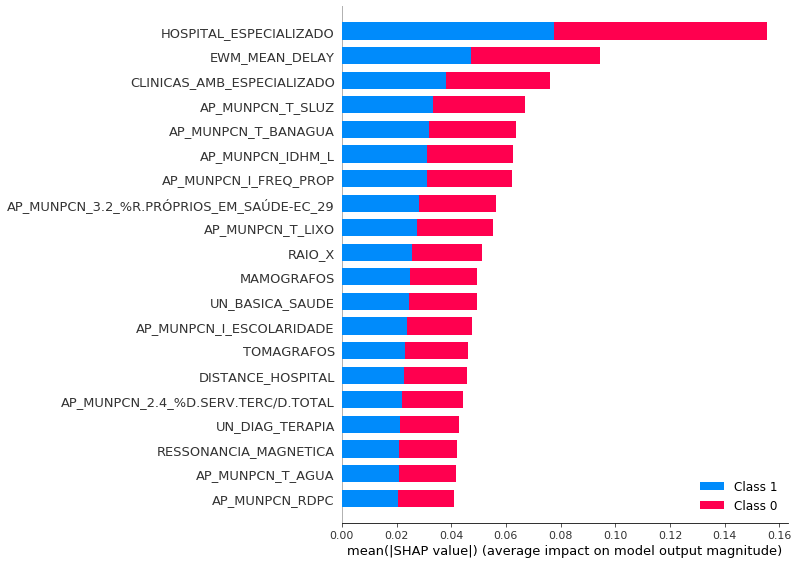

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")